In [1]:
from numpwd.integrate.numeric import ExpressionMap
from numpwd.densities.h5 import read_h5
from numpwd.operators.base import Operator
from numpwd.convolution.channels import get_channel_overlap_indices
from scipy.interpolate import interp1d

import matplotlib.pylab as plt
from pandas import DataFrame
import pandas as pd
import seaborn as sns
from sympy import sympify
import numpy as np
import os
import re

## Setup

In [2]:
DATA_4HE_AV18 = os.path.join(os.environ["HOME"], "data", "nuc", "4he", "av18")

files = [f for f in os.listdir(DATA_4HE_AV18) if f.endswith(".h5")]
print("First rho1b file", files[0])

DATA_FF = "/home/ckoerber/data/nuc/NucleonFFData"
print("\nFF data:", os.listdir(DATA_FF))

First rho1b file compton-dens-4he-av18-empot-no3nf-om=0.00E+00-th=1.80E+02-nx=16-nphi=16-np12=np34=28+8-np3=36+8-nq4=nq=36+6-j12max=5-lmax=6-lsummax=14-tau4max=0-rho.h5

FF data: ['proton_baseline_sep272019_RE8414.dat', 'Ye2017gyb_neutron_lookup.dat']


In [3]:
patterns = (
    r"compton-dens-(?P<nuc>[0-9A-z]+)",
    r"\-(?P<potential>[a-z0-9]+)",
    r"(?:\-(?P<empot>(?:empot)))?",
    r"(?:\-(?P<tnf>(?:[a-z0-9]+)))?",
    r"(?:\-Lamnum=(?P<lambda>(?:[0-9\.e\+]+)))?",
    r"(?:\-tnfcut=(?P<tnfcut>(?:[0-9]+)))?",
    r"\-om=(?P<omega>(?:[0-9\.]+E[\+\-][0-9]+))",
    r"\-th=(?P<theta>(?:[0-9\.E\+]+))",
    r"\-nx=(?P<nx>(?:[0-9]+))",
    r"\-nphi=(?P<nphi>(?:[0-9]+))",
    r"\-np12\=np34\=(?P<np12_np34>(?:[0-9\+]+))",
    r"\-np3\=(?P<np3>(?:[0-9\+]+))",
    r"\-nq4\=nq=(?P<nq4_nq>(?:[0-9\+]+))",
    r"\-j12max=(?P<j12max>(?:[0-9]+))",
    r"\-lmax=(?P<lmax>(?:[0-9]+))",
    r"\-lsummax=(?P<lsummax>(?:[0-9]+))",
    r"\-tau4max=(?P<tau4max>(?:[0-9]+))",
    r"\-rho\.h5",
)
pattern = re.compile("".join(patterns))
pattern.search(files[0]).groupdict()

{'nuc': '4he',
 'potential': 'av18',
 'empot': 'empot',
 'tnf': 'no3nf',
 'lambda': None,
 'tnfcut': None,
 'omega': '0.00E+00',
 'theta': '1.80E+02',
 'nx': '16',
 'nphi': '16',
 'np12_np34': '28+8',
 'np3': '36+8',
 'nq4_nq': '36+6',
 'j12max': '5',
 'lmax': '6',
 'lsummax': '14',
 'tau4max': '0'}

In [4]:
dtypes = {
    int: ["nx", "nphi", "j12max", "lmax", "lsummax", "tau4max"],
    float: ["lambda", "omega", "theta"],
}

In [5]:
data = [pattern.search(f).groupdict() for f in files]
df = pd.DataFrame(data)
for dtype, cols in dtypes.items():
    for col in cols:
        df[col] = df[col].astype(dtype)

df["file"] = files
df.head()

,nuc,potential,empot,tnf,lambda,tnfcut,omega,theta,nx,nphi,np12_np34,np3,nq4_nq,j12max,lmax,lsummax,tau4max,file
0,4he,av18,empot,no3nf,NaN,None,0.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=0.00E+00-...
1,4he,av18,empot,no3nf,NaN,None,49.3,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=4.93E+01-...
2,4he,av18,empot,no3nf,NaN,None,10.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=1.00E+01-...
3,4he,av18,empot,no3nf,NaN,None,70.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=7.00E+01-...
4,4he,av18,empot,no3nf,NaN,None,90.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=9.00E+01-...


In [6]:
f = df["file"].values[0]
dens = read_h5(os.path.join(DATA_4HE_AV18, f))
dens.current_info

{'qval': 0.0,
 'omval': 0.0,
 'thetaqval': 1.5707963267948966,
 'thetaval': 3.141592653589793}

This is a pure contact interaction. So $l_i = l_o = 0$

## Form factor corrections (not included yet)

In [7]:
def dipole_FF(q2):
    """Returns dipole form factor named GD in notes.
    
    Here, q2 is in GeV**2"""
    return 1 / (1 + q2 / (0.71)) ** 2

In [8]:
# Read in data
gp_data = (
    pd.read_csv(
        os.path.join(DATA_FF, "proton_baseline_sep272019_RE8414.dat"), sep="\s+",
    )
    .set_index("Q2")
    .rename(columns={"GEp/GD": "gep", "GMp/muGD": "gmp"})[["gep", "gmp"]]
)

# Mutliply by GD
gp_data["gep"] *= dipole_FF(gp_data.index.values)
gp_data["gmp"] *= dipole_FF(gp_data.index.values)

# convert q2 to MeV**2
gp_data.index = gp_data.index * 1000 ** 2

# Interpolate
gep = interp1d(gp_data.index, gp_data.gep.values, kind="cubic")
gmp = interp1d(gp_data.index, gp_data.gmp.values, kind="cubic")

# Read in data
gn_data = (
    pd.read_csv(os.path.join(DATA_FF, "Ye2017gyb_neutron_lookup.dat"), sep="\s+",)
    .set_index("Q2")
    .rename(columns={"GEn/GD": "gen", "GMn/muGD": "gmn"})[["gen", "gmn"]]
)

# Mutliply by GD
gn_data["gen"] *= dipole_FF(gp_data.index.values)
gn_data["gmn"] *= dipole_FF(gp_data.index.values)

# convert q2 to MeV**2
gn_data.index = gn_data.index * 1000 ** 2

# Interpolate
gen = interp1d(gn_data.index, gn_data.gen.values, kind="cubic")
gmn = interp1d(gn_data.index, gn_data.gmn.values, kind="cubic")

HBARC = 197.3269804


def ges_correction(k2_ifm):
    """
    """
    k2_MeV = k2_ifm * HBARC + 1.0
    gep_k2, gen_k2 = gep(k2_MeV), gen(k2_MeV)
    return (gep_k2 + gen_k2) / 2

## Operator comutations

In [9]:
def get_contact_frame(dens):
    id_dens = dens.channels.query(
        "mj_o == mj_i and l_o == l_i == 0 and s_o == s_i and j_o == j_i and t_o == t_i and mt_o == mt_i"
    ).index
    weight = dens.p ** 2 * dens.wp
    weight = weight.reshape(1, len(weight), 1) * weight.reshape(1, 1, len(weight))
    channel_res = np.sum(dens.matrix[id_dens] * weight, axis=(1, 2))
    df = dens.channels.copy().loc[id_dens]
    df["res"] = channel_res
    return df

In [10]:
get_contact_frame(dens).head()

,l_o,s_o,j_o,t_o,mt_o,mj_o,mjtotx2_o,l_i,s_i,j_i,t_i,mt_i,mj_i,mjtotx2_i,res
id,,,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0.001119
1144,0,1,1,0,0,-1,0,0,1,1,0,0,-1,0,0.002867
1287,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0.002867
1430,0,1,1,0,0,1,0,0,1,1,0,0,1,0,0.002867
20164,0,0,0,1,-1,0,0,0,0,0,1,-1,0,0,0.001119


In [11]:
def op_a(df, k2):
    return df["res"].sum() * k2  # * ges_correction(k2)

In [12]:
def op_b(df, k2):
    out = 0
    grouped = df.groupby("s_o")
    for so, group in grouped:
        out += group["res"].sum() * k2 * (-3 if so == 0 else 1)
    return out  # * ges_correction(k2*HBARC)

The c factor is effectively
$$ (-1)^{m_s + 1} $$

Thus the $(ls)jm_j$ contraction becomes
$$
    \sum_{m_l m_s}
    < l m_l, s m_s | j m_j>
    < l m_l, s m_s | j' m_j'> (-1)^{m_s +1}
$$
$$
    -\delta_{j j'}\delta_{m_j m_j'}\delta_{s 0}
    +\delta_{s 1}
    \left(\sum_{m_l m_s}
    < l m_l, 1 m_s | j m_j>
    < l m_l, 1 m_s | j' m_j'>
    -2
    < l m_j, 1 0 | j m_j>
    < l m_j, 1 0 | j' m_j>\right)
$$
and using that $l=0$
$$
    < 0 0, 1 0 | j 0>
    =
    \delta_{j1}
$$

In [13]:
def op_c(df, k2):
    out = 0
    grouped = df.groupby(["s_o", "mj_o"])
    for (s, mj), group in grouped:
        if s == 0:
            fact = -1
        elif s == 1 and mj != 0:
            fact = 1
        elif s == 1 and mj == 0:
            fact = -1
        out += group["res"].sum() * k2 * fact
    return out  # * ges_correction(k2)

## Computations

In [14]:
FPI = 0.0924e3 / HBARC
LB = 0.650e3 / HBARC

In [15]:
def get_contributions(filename: str):
    dens = read_h5(os.path.join(DATA_4HE_AV18, filename))
    df = get_contact_frame(dens)
    k2 = dens.current_info["qval"] ** 2
    return (
        pd.Series({"A": op_a(df, k2), "B": op_b(df, k2), "C": op_c(df, k2), "k2": k2})
        / FPI ** 2
        / LB ** 3
    )

In [16]:
res = df.join(df["file"].apply(get_contributions))

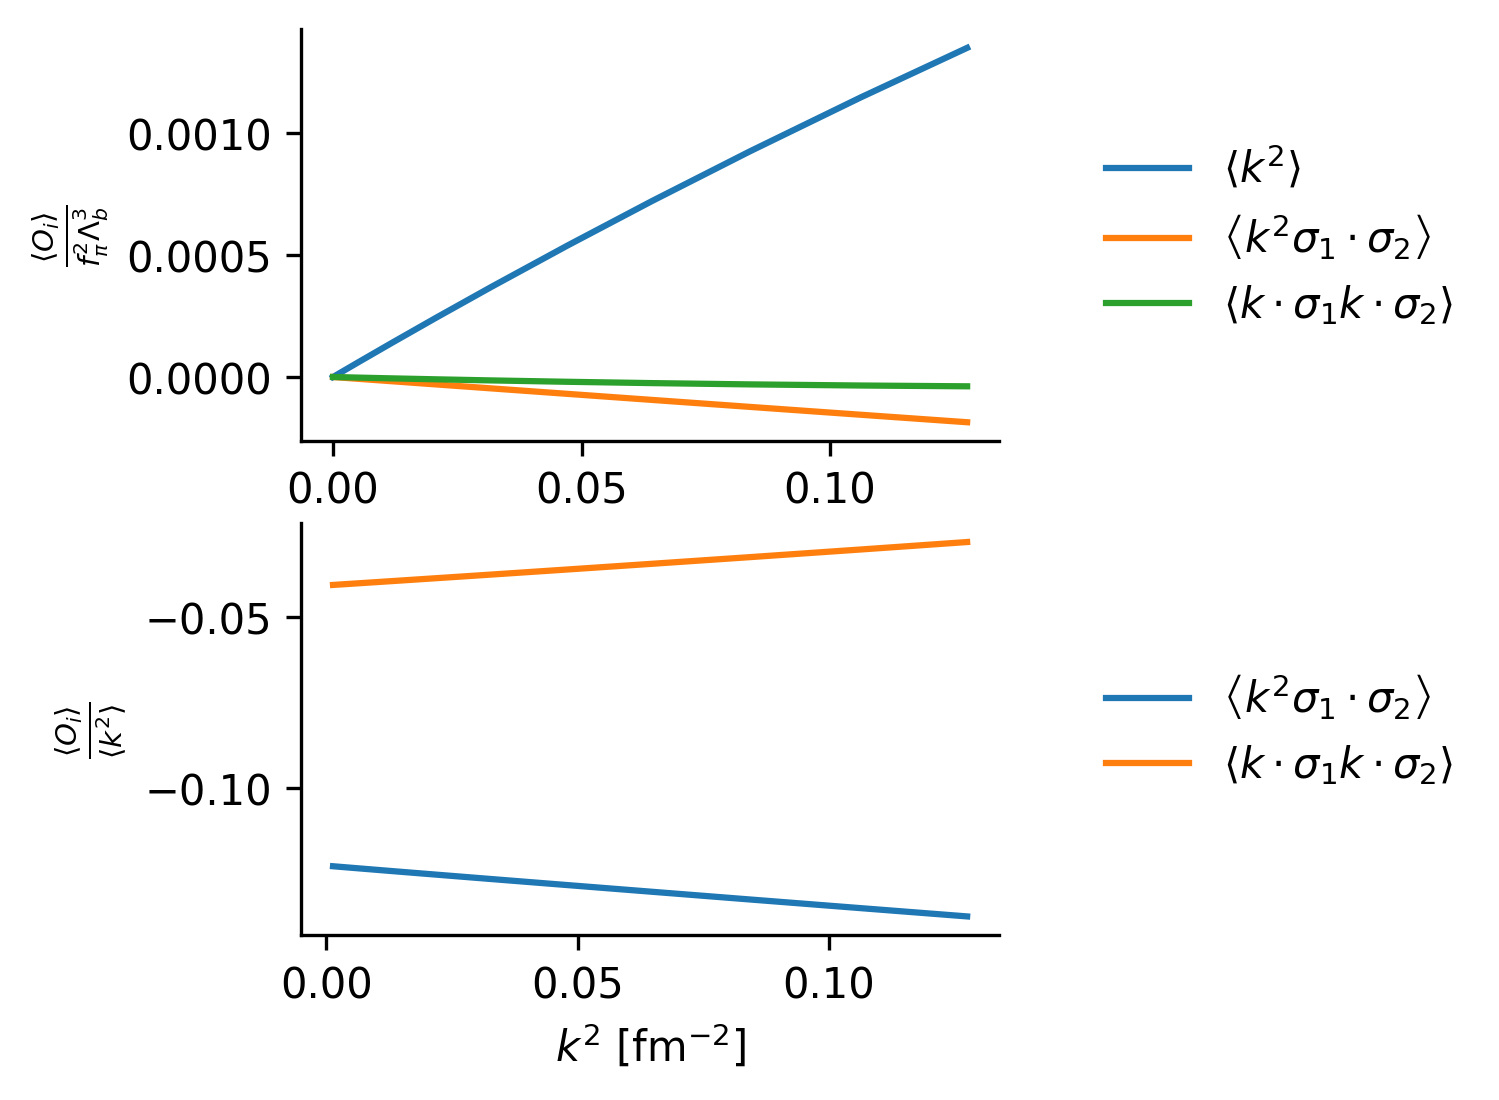

In [17]:
fig, axs = plt.subplots(figsize=(3, 4), dpi=300, nrows=2)

ax = axs[0]

tmp = res[["k2", "A", "B", "C"]].sort_values("k2").set_index("k2")

tmp.rename(
    columns={
        "A": r"$\left\langle k^2 \right\rangle$",
        "B": r"$\left\langle k^2 \sigma_1 \cdot \sigma_2 \right\rangle$",
        "C": r"$\left\langle k \cdot \sigma_1 k \cdot \sigma_2 \right\rangle$",
    }
).plot(ax=ax)

ax.set_ylabel(r"$\frac{\left\langle O_i \right\rangle}{f_\pi^2 \Lambda_b^3}$")
ax.set_xlabel("$k^2$ [fm$^{-2}$]")
ax.legend(fancybox=False, frameon=False, bbox_to_anchor=(1.1, 0.5), loc="center left")
# ax.set_title(label, size=8)

ax = axs[1]

(tmp[["B", "C"]].T / tmp["A"].values).T.rename(
    columns={
        "A": r"$\left\langle k^2 \right\rangle$",
        "B": r"$\left\langle k^2 \sigma_1 \cdot \sigma_2 \right\rangle$",
        "C": r"$\left\langle k \cdot \sigma_1 k \cdot \sigma_2 \right\rangle$",
    }
).plot(ax=ax)
ax.set_ylabel(
    r"$\frac{\left\langle O_i \right\rangle}{\left\langle k^2 \right\rangle}$"
)
ax.set_xlabel("$k^2$ [fm$^{-2}$]")
ax.legend(fancybox=False, frameon=False, bbox_to_anchor=(1.1, 0.5), loc="center left")
sns.despine()


plt.show()

In [19]:
fig.savefig("2n-contact-contributions-4he-av18.pdf", bbox_inches="tight")